# Age discrepancy

Now we will try to correlate age discrepancy with some scores of the behavioral dataset. Our model to predict age uses only the structural MRI features.

In [1]:
import warnings
warnings.filterwarnings('ignore')
from utils import create_dataset_mri, cv_for_cde, create_dataset_eeg
from cde.density_estimator import MixtureDensityNetwork
import numpy as np
import tensorflow as tf
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from tensorflow.python.keras.activations import tanh
from sklearn.impute import SimpleImputer
import pandas as pd
import tensorflow as tf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
# Behavioral data
behavioral = pd.read_csv('data/Behavioral/cleaned/HBNFinalSummaries.csv')
# Create dataset MRI
target = 'Age'
data = create_dataset_mri(SCORE = target)
data.drop(columns=['DX_01_Cat', 'DX_01_Sub', 'DX_01'], inplace=True)

In [3]:
# labels and features
y = data[target]
X = data.drop([target], axis=1)
X = np.array(X)
y = np.array(y)

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=12)   #rs=2
y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))
ID_train = X_train[:,0]
X_train = X_train[:,1:]
ID_test = X_test[:,0]
X_test = X_test[:,1:]
y_train = np.array(y_train, dtype=np.float64)
X_train = np.array(X_train, dtype=np.float64)
y_test = np.array(y_test, dtype=np.float64)
X_test = np.array(X_test, dtype=np.float64)
print(X_train.shape)

(573, 369)


In [4]:
# Set model parameters
ndim_x=X_train.shape[1]
ndim_y=y_train.shape[1]
# We try the "faster decay rate for non-gaussian data" proposed in the paper: h = n^(-1/(d+1))
n = X_train.shape[0]
d = X_train.shape[1]+y_train.shape[1]
h = n**(-1/(d+1))
# Define the model
model = MixtureDensityNetwork('MDN', ndim_x, ndim_y, n_centers=10, hidden_sizes=(16, 16), hidden_nonlinearity=tf.nn.tanh,
               n_training_epochs=1000, x_noise_std=h, y_noise_std=h, adaptive_noise_fn=None, entropy_reg_coef=0.0,
               weight_decay=0.0, weight_normalization=True, data_normalization=True, dropout=0.0, l2_reg=0.0, l1_reg=0.0,
               random_seed=42)
# Fit
model.fit(X_train, y_train)
# Predict
y_pred = model.mean_(X_test)
y_pred = y_pred.reshape((-1,1))
y_pred.shape
print('Test MSE: {}'.format(mean_squared_error(y_pred, y_test)))

1000/1000 [100%] ██████████████████████████████ Elapsed: 12s | loss: 839.704
mean log-loss train: 1.4655
Test MSE: 5.401501241648076


In [5]:
# Define discrepancy
std = model.std_(X_test)
discrepancy = np.divide((y_test-y_pred), std)
#discrepancy = y_test-y_pred

In [6]:
# Get dataframe for test observations with behavioral data + discrepancy
data = {'discrepancy':discrepancy[:,0]}
discrepancy_df = pd.DataFrame(data)
ID_df = pd.DataFrame({'EID':ID_test})
discrepancy_merged = pd.concat([ID_df, discrepancy_df], axis=1)
dataframe = pd.merge(discrepancy_merged, behavioral, how='inner', on='EID')
dataframe = dataframe.drop(['Anonymized.ID', 'Study.Site'], axis = 1)

In [7]:
# Get the correlations
correlations = dataframe[dataframe.columns[1:]].corr()['discrepancy'][:]
# Inspect correlations
correlations[correlations > 0.3]  

discrepancy                        1.000000
Age                                0.475241
DX_08_ByHx                         1.000000
CBCL_Pre_WD                        0.417865
CBCL_Pre_Ext                       0.303648
CBCL_Pre_Int                       0.343902
CBCL_Pre_Total                     0.358477
CLEF5M_FL_Raw                      0.339486
KBIT_NV_Raw                        0.336798
KBIT_V_Raw                         0.502948
Picture_Seq_Raw                    0.325119
SRS_Pre_COM                        0.359951
SRS_Pre_MOT                        0.450541
SRS_Pre_SCI                        0.377398
SRS_Pre_Total                      0.370962
TRF_Pre_Attention_Raw              0.579834
TRF_Pre_Withdrawn.Depressed_Raw    0.327105
VL_Comm3_Raw                       0.730172
WASI_Vocab_Raw                     0.365518
WASI_BD_Raw                        0.330062
WIAT_Num_Raw                       0.322963
WIAT_Spell_Raw                     0.326315
WIAT_LCRV_Raw                   

In [8]:
# Frequencies of major disturb in behavioral dataset
dataframe['DX_01'].value_counts()

ADHD-Combined Type                                           111
ADHD-Inattentive Type                                        103
No Diagnosis Given                                            73
No Diagnosis Given: Incomplete Eval                           41
Autism Spectrum Disorder                                      37
Specific Learning Disorder with Impairment in Reading         32
Generalized Anxiety Disorder                                  21
Other Specified Attention-Deficit/Hyperactivity Disorder      20
Social Anxiety (Social Phobia)                                18
Major Depressive Disorder                                     14
Other Specified Anxiety Disorder                              13
ADHD-Hyperactive/Impulsive Type                               11
Language Disorder                                             10
Intellectual Disability-Mild                                   8
Other Specified Depressive Disorder                            5
Adjustment Disorders     

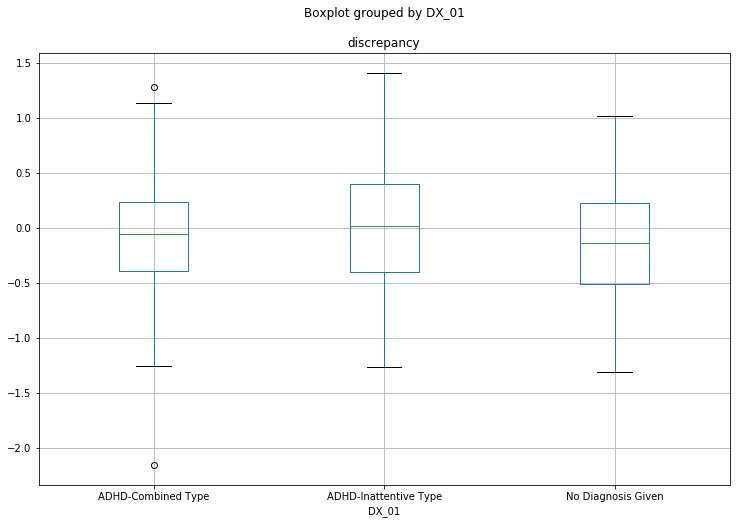

In [9]:
df = dataframe.loc[dataframe['DX_01'].isin(['ADHD-Inattentive Type', 'ADHD-Combined Type', 'No Diagnosis Given'])]
#Create a boxplot
df.boxplot('discrepancy', by='DX_01', figsize=(12, 8))

## ANOVA

In [10]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('discrepancy ~ DX_01',                 # Model formula
            data = df).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)

             sum_sq     df        F    PR(>F)
DX_01      1.615185    2.0  2.75187  0.065511
Residual  83.345634  284.0      NaN       NaN


In [11]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            discrepancy   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.752
Date:                Wed, 13 Nov 2019   Prob (F-statistic):             0.0655
Time:                        22:26:39   Log-Likelihood:                -229.80
No. Observations:                 287   AIC:                             465.6
Df Residuals:                     284   BIC:                             476.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -0.0668      0.051     -1.300      0.195      -0.168       0.034
DX_01[T.ADHD-Inattentive Type]     0.1116      0.074      1.506      0.133      -0.034       0.257
DX_01[T.No Diagnosis Given]       -0.0784      0.082     -0.960      0.338      -0.239       0.082
==============================================================================
Omnibus:                        2.660   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.264   Jarque-Bera (JB):                2.820
Skew:                          -0.017   Prob(JB):                        0.244
Kurtosis:                       3.484   Cond. No.                         3.54
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
adhd = df[df['DX_01'] == 'ADHD-Inattentive Type']['discrepancy']
no_adhd = df[df['DX_01'] == 'No Diagnosis Given']['discrepancy']
from scipy.stats import ttest_ind
res = ttest_ind(np.array(adhd), np.array(no_adhd), equal_var=False)
res

Ttest_indResult(statistic=2.2901862868163034, pvalue=0.023251431556662913)

In [13]:
df = dataframe.loc[dataframe['DX_01'].isin(['ADHD-Inattentive Type', 'No Diagnosis Given'])]
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('discrepancy ~ DX_01',                 # Model formula
            data = df).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)

             sum_sq     df          F    PR(>F)
DX_01      3.784010    1.0  12.146321  0.000622
Residual  54.207179  174.0        NaN       NaN


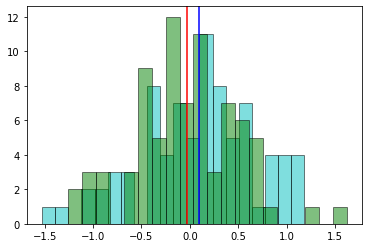

In [16]:
import matplotlib.pyplot as plt
plt.hist(adhd[:80], bins=20, color='c', edgecolor='k', alpha=0.5)     # take same number of obs as no_adhd
plt.hist(no_adhd, bins=20, color='g', edgecolor='k', alpha=0.5)
plt.axvline(x=np.mean(adhd[:no_adhd.shape[0]]), color = 'b')
plt.axvline(x=np.mean(no_adhd), color = 'r')

The light-blue histogram is relative to adhd patients, the green one to healthy patients. Due to the high variance the two distributions overlap a lot and maybe that's why we get a non-significant p-value?

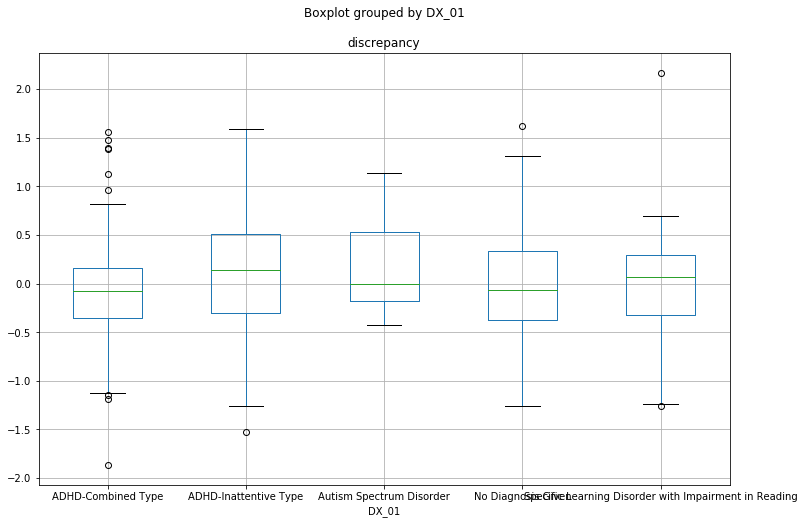

In [14]:
df = dataframe.loc[dataframe['DX_01'].isin(['ADHD-Combined Type', 'ADHD-Inattentive Type','No Diagnosis Given', 'Autism Spectrum Disorder', 'Specific Learning Disorder with Impairment in Reading'])]
#Create a boxplot
df.boxplot('discrepancy', by='DX_01', figsize=(12, 8))

In [15]:
model = ols('discrepancy ~ DX_01',                 # Model formula
            data = df).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)

              sum_sq     df         F    PR(>F)
DX_01       2.318044    4.0  1.798752  0.128791
Residual  103.417859  321.0       NaN       NaN


In [16]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            discrepancy   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.799
Date:                Wed, 13 Nov 2019   Prob (F-statistic):              0.129
Time:                        21:40:32   Log-Likelihood:                -275.43
No. Observations:                 326   AIC:                             560.9
Df Residuals:                     321   BIC:                             579.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                         -0.0728      0.055     -1.320      0.188      -0.181       0.036
DX_01[T.ADHD-Inattentive Type]                                     0.1866      0.081      2.300      0.022       0.027       0.346
DX_01[T.Autism Spectrum Disorder]                                  0.2187      0.126      1.733      0.084      -0.030       0.467
DX_01[T.No Diagnosis Given]                                        0.0392      0.084      0.465      0.642      -0.127       0.205
DX_01[T.Specific Learning Disorder with Impairment in Reading]     0.0888      0.126      0.703      0.482      -0.160       0.337
==============================================================================
Omnibus:                       10.930   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               17.545
Skew:                           0.202   Prob(JB):                     0.000155
Kurtosis:                       4.063   Cond. No.                         5.27
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
# Consider all the diseases, F-test still significant.
model = ols('discrepancy ~ DX_01',                 # Model formula
            data = dataframe).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)

              sum_sq     df         F    PR(>F)
DX_01      22.854937   45.0  1.402017  0.047414
Residual  186.199037  514.0       NaN       NaN


# Consider also Age

In [18]:
df = dataframe.loc[dataframe['DX_01'].isin(['ADHD-Combined Type', 'ADHD-Inattentive Type','No Diagnosis Given', 'Autism Spectrum Disorder', 'Specific Learning Disorder with Impairment in Reading'])]
df['Age'] = np.floor(df['Age'])

model = ols('discrepancy ~ Age + DX_01',                 # Model formula
            data = df).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)

             sum_sq     df          F        PR(>F)
DX_01      2.654268    4.0   2.267276  6.173816e-02
Age       21.355726    1.0  72.968250  4.790468e-16
Residual  97.459605  333.0        NaN           NaN


In [19]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            discrepancy   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     19.24
Date:                Wed, 13 Nov 2019   Prob (F-statistic):           7.98e-17
Time:                        21:34:09   Log-Likelihood:                -269.73
No. Observations:                 339   AIC:                             551.5
Df Residuals:                     333   BIC:                             574.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                         -0.7894      0.092     -8.575      0.000      -0.970      -0.608
DX_01[T.ADHD-Inattentive Type]                                     0.1115      0.080      1.386      0.167      -0.047       0.270
DX_01[T.Autism Spectrum Disorder]                                  0.2976      0.108      2.749      0.006       0.085       0.511
DX_01[T.No Diagnosis Given]                                        0.0101      0.082      0.124      0.902      -0.151       0.171
DX_01[T.Specific Learning Disorder with Impairment in Reading]     0.0680      0.111      0.612      0.541      -0.151       0.287
Age                                                                0.0723      0.008      8.542      0.000       0.056       0.089
==============================================================================
Omnibus:                        6.357   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                7.189
Skew:                          -0.207   Prob(JB):                       0.0275
Kurtosis:                       3.581   Cond. No.                         51.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

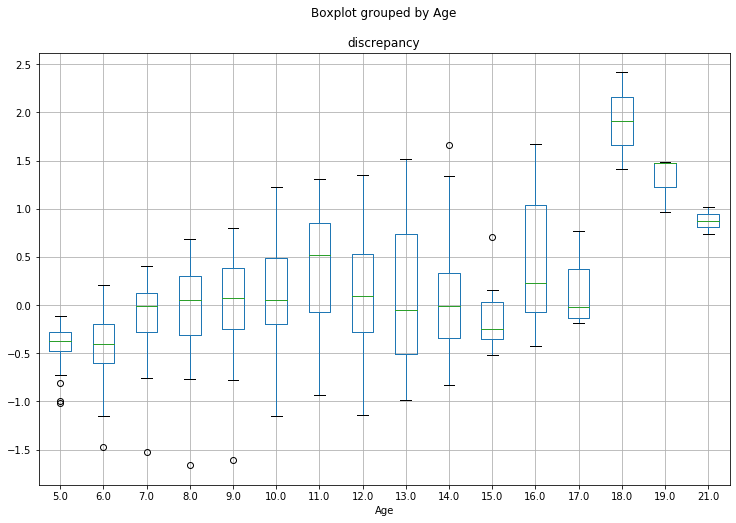

In [25]:
#Create a boxplot
df.boxplot('discrepancy', by='Age', figsize=(12, 8))

We note that age is highly significant in the discrepancy of age itself. For some reason the discrepancy is always high for patients aged 17+. What if we focus on patients aged 5-17?

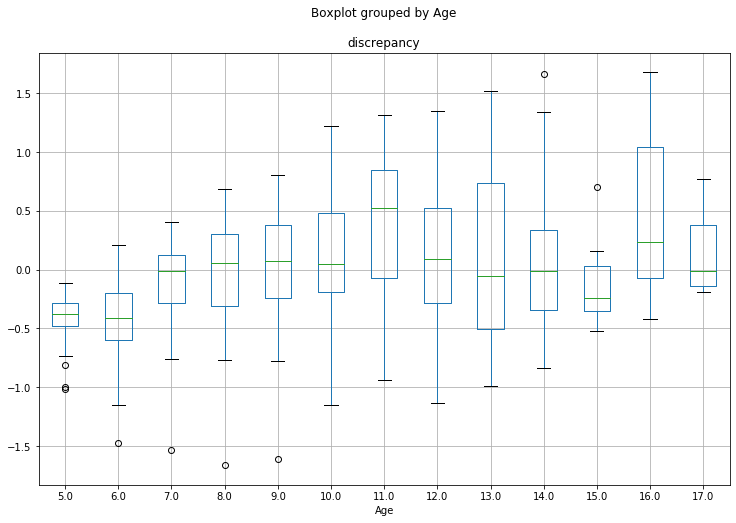

In [26]:
df = dataframe.loc[dataframe['DX_01'].isin(['ADHD-Combined Type', 'ADHD-Inattentive Type','No Diagnosis Given', 'Autism Spectrum Disorder', 'Specific Learning Disorder with Impairment in Reading'])]
dataframe['Age'] = np.floor(dataframe['Age'])
df = df.loc[df['Age']<18]
#Create a boxplot
df.boxplot('discrepancy', by='Age', figsize=(12, 8))

In [24]:
model = ols('discrepancy ~ Age + DX_01',                 # Model formula
            data = df).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)
model.summary()

             sum_sq     df          F        PR(>F)
DX_01      0.664626    4.0   0.656595  6.226102e-01
Age       22.439351    1.0  88.672815  9.548962e-19
Residual  80.978508  320.0        NaN           NaN


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            discrepancy   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     19.57
Date:                Wed, 13 Nov 2019   Prob (F-statistic):           5.23e-17
Time:                        22:06:28   Log-Likelihood:                -235.56
No. Observations:                 326   AIC:                             483.1
Df Residuals:                     320   BIC:                             505.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                         -0.8017      0.092     -8.758      0.000      -0.982      -0.622
DX_01[T.ADHD-Inattentive Type]                                     0.0130      0.074      0.175      0.861      -0.133       0.159
DX_01[T.Autism Spectrum Disorder]                                  0.1156      0.112      1.029      0.304      -0.105       0.337
DX_01[T.No Diagnosis Given]                                       -0.0576      0.075     -0.763      0.446      -0.206       0.091
DX_01[T.Specific Learning Disorder with Impairment in Reading]    -0.0498      0.113     -0.442      0.659      -0.272       0.172
Age                                                                0.0806      0.009      9.417      0.000       0.064       0.097
==============================================================================
Omnibus:                        8.641   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                8.714
Skew:                          -0.345   Prob(JB):                       0.0128
Kurtosis:                       3.408   Cond. No.                         52.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
anova_result.loc['DX_01','PR(>F)']

0.6226102445064063

# Evaluate on many splits

In [2]:
def F_test(repetitions):
    # Behavioral data
    behavioral = pd.read_csv('data/Behavioral/cleaned/HBNFinalSummaries.csv')
    # Create dataset MRI
    target = 'Age'
    data = create_dataset_mri(SCORE = target)
    data.drop(columns=['DX_01_Cat', 'DX_01_Sub', 'DX_01'], inplace=True)
    # labels and features
    y = data[target]
    X = data.drop([target], axis=1)
    X = np.array(X)
    y = np.array(y)
    F = []
    t = []
    for i in range(repetitions):
        # split the dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=i)   #rs=2
        y_train = y_train.reshape((-1,1))
        y_test = y_test.reshape((-1,1))
        ID_train = X_train[:,0]
        X_train = X_train[:,1:]
        ID_test = X_test[:,0]
        X_test = X_test[:,1:]
        y_train = np.array(y_train, dtype=np.float64)
        X_train = np.array(X_train, dtype=np.float64)
        y_test = np.array(y_test, dtype=np.float64)
        X_test = np.array(X_test, dtype=np.float64)
        # Set model parameters
        ndim_x=X_train.shape[1]
        ndim_y=y_train.shape[1]
        # We try the "faster decay rate for non-gaussian data" proposed in the paper: h = n^(-1/(d+1))
        n = X_train.shape[0]
        d = X_train.shape[1]+y_train.shape[1]
        h = n**(-1/(d+1))
        model = MixtureDensityNetwork('{}'.format(i), ndim_x, ndim_y, n_centers=10, hidden_sizes=(16, 16), hidden_nonlinearity=tf.nn.tanh,
               n_training_epochs=1000, x_noise_std=h, y_noise_std=h, adaptive_noise_fn=None, entropy_reg_coef=0.0,
               weight_decay=0.0, weight_normalization=True, data_normalization=True, dropout=0.0, l2_reg=0.0, l1_reg=0.0,
               random_seed=42)
        # Fit
        model.fit(X_train, y_train)
        # Predict
        y_pred = model.mean_(X_test)
        y_pred = y_pred.reshape((-1,1))
        # Define discrepancy
        std = model.std_(X_test)
        discrepancy = np.divide((y_test-y_pred), std)
        # Get dataframe for test observations with behavioral data + discrepancy
        data = {'discrepancy':discrepancy[:,0]}
        discrepancy_df = pd.DataFrame(data)
        ID_df = pd.DataFrame({'EID':ID_test})
        discrepancy_merged = pd.concat([ID_df, discrepancy_df], axis=1)
        dataframe = pd.merge(discrepancy_merged, behavioral, how='inner', on='EID')
        dataframe = dataframe.drop(['Anonymized.ID', 'Study.Site'], axis = 1)
        # Select most frequent diseases
        df = dataframe.loc[dataframe['DX_01'].isin(['ADHD-Combined Type', 'ADHD-Inattentive Type','No Diagnosis Given', 'Autism Spectrum Disorder', 'Specific Learning Disorder with Impairment in Reading'])]
        #Create a boxplot
        #df.boxplot('discrepancy', by='DX_01', figsize=(12, 8))
        model = ols('discrepancy ~ DX_01',                 # Model formula
                data = df).fit()
        anova_result = sm.stats.anova_lm(model, typ=2)
        F.append(anova_result.loc['DX_01','PR(>F)'])
        adhd = df[df['DX_01'] == 'ADHD-Inattentive Type']['discrepancy']
        no_adhd = df[df['DX_01'] == 'No Diagnosis Given']['discrepancy']
        res = ttest_ind(np.array(adhd), np.array(no_adhd), equal_var=False)
        t.append(res[1])
    print('Mean F-test p-val: {} \n Mean t-test p-val: {}'.format(np.mean(F), np.mean(t)))


In [3]:
F_test(30)

1000/1000 [100%] ██████████████████████████████ Elapsed: 12s | loss: 836.487
mean log-loss train: 1.4598
1000/1000 [100%] ██████████████████████████████ Elapsed: 12s | loss: 813.083
mean log-loss train: 1.4190
1000/1000 [100%] ██████████████████████████████ Elapsed: 14s | loss: 837.330
mean log-loss train: 1.4613
1000/1000 [100%] ██████████████████████████████ Elapsed: 14s | loss: 854.935
mean log-loss train: 1.4920
1000/1000 [100%] ██████████████████████████████ Elapsed: 15s | loss: 828.355
mean log-loss train: 1.4456
1000/1000 [100%] ██████████████████████████████ Elapsed: 15s | loss: 834.344
mean log-loss train: 1.4561
1000/1000 [100%] ██████████████████████████████ Elapsed: 15s | loss: 892.617
mean log-loss train: 1.5578
1000/1000 [100%] ██████████████████████████████ Elapsed: 16s | loss: 816.586
mean log-loss train: 1.4251
1000/1000 [100%] ██████████████████████████████ Elapsed: 16s | loss: 831.396
mean log-loss train: 1.4510
1000/1000 [100%] ██████████████████████████████ Elapsed